In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#ensemble learning using stacking
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from skimage import data, color, feature
from skimage.feature import hog
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report


In [3]:
# Load and preprocess the training data for CNN
def load_data(fruit, tipo):
    label = []
    arr = []
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/"+fruit+"/"+tipo+"/*"
    for file_ in glob.glob(strr):
        img = cv2.imread(file_)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        arr.append(img)
        label.append(fruit)
    return arr, label

In [4]:
# Function to load the whole dataset
def whole_train_data(tipo):
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)
    data = np.concatenate((closed_data, open_data, road_data))
    labels = np.concatenate((closed_label, open_label, road_label))
    return data, labels

In [5]:
data_train, labels_train = whole_train_data('Train')
data_test, labels_test = whole_train_data('Test')

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [6]:
def preprocessing(arr):
    arr_prep = []
    for i in range(arr.shape[0]):
        img = cv2.cvtColor(arr[i], cv2.COLOR_BGR2GRAY)
        img = resize(img, (72, 72), anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep

In [7]:
data_train_p = np.array(preprocessing(data_train))
data_test_p = np.array(preprocessing(data_test))

In [8]:
data_train_p = np.expand_dims(data_train_p, axis=-1)
data_test_p = np.expand_dims(data_test_p, axis=-1)

In [9]:
input_shape = (72, 72, 1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [10]:
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# One-hot encoding of labels for CNN
labels_train_one_hot = tf.keras.utils.to_categorical(labels_train_encoded)
labels_test_one_hot = tf.keras.utils.to_categorical(labels_test_encoded)


In [13]:
print("Shape of data_train_p:", data_train_p.shape)
print("Shape of labels_train_encoded:", labels_train_encoded.shape)

Shape of data_train_p: (3715, 72, 72, 1)
Shape of labels_train_encoded: (3715,)


In [14]:
model.fit(data_train_p, labels_train_one_hot, epochs=10, batch_size=32)
test_loss, test_acc = model.evaluate(data_test_p, labels_test_one_hot)

Epoch 1/10
117/117 [==============================] - 24s 199ms/step - loss: 0.8823 - accuracy: 0.5801
Epoch 2/10
117/117 [==============================] - 22s 189ms/step - loss: 0.6585 - accuracy: 0.7176
Epoch 3/10
117/117 [==============================] - 24s 201ms/step - loss: 0.5560 - accuracy: 0.7658
Epoch 4/10
117/117 [==============================] - 22s 187ms/step - loss: 0.4743 - accuracy: 0.8016
Epoch 5/10
117/117 [==============================] - 24s 203ms/step - loss: 0.4034 - accuracy: 0.8423
Epoch 6/10
117/117 [==============================] - 22s 187ms/step - loss: 0.3222 - accuracy: 0.8738
Epoch 7/10
117/117 [==============================] - 24s 204ms/step - loss: 0.2532 - accuracy: 0.8988
Epoch 8/10
117/117 [==============================] - 23s 196ms/step - loss: 0.1981 - accuracy: 0.9281
Epoch 9/10
117/117 [==============================] - 23s 193ms/step - loss: 0.1614 - accuracy: 0.9419
Epoch 10/10
32/32 [==============================] - 2s 42ms/step - loss:

In [15]:
print('CNN Test Loss:', test_loss)
print('CNN Test Accuracy:', test_acc*100, "%")

CNN Test Loss: 0.46795955300331116
CNN Test Accuracy: 85.7427716255188 %


In [16]:
# Load and preprocess the training data for other models (Random Forest, SVM, KNN)
def ExtractHOG(img):
    ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), visualize=True, multichannel=True, channel_axis=-1)
    return ftr

In [17]:
def preprocessing_part_two(arr):
    arr_feature = []
    for i in range(np.shape(arr)[0]):
        arr_feature.append(ExtractHOG(arr[i]))
    return arr_feature

In [18]:
data_train_ftr = preprocessing_part_two(data_train_p)
data_test_ftr = preprocessing_part_two(data_test_p)

<ipython-input-16-4e5de42a5e7f>:3: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),


In [19]:
# Train Random Forest model
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(data_train_ftr, labels_train_encoded)

RandomForestClassifier()

In [20]:
# Train SVM model
svm_clf = SVC(kernel='linear')
svm_clf.fit(data_train_ftr, labels_train_encoded)

SVC(kernel='linear')

In [21]:
# Train KNN model
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(data_train_ftr, labels_train_encoded)

KNeighborsClassifier(n_neighbors=3)

In [22]:
# Generate predictions of base models on training data for stacking
rf_train_pred = random_forest.predict(data_train_ftr)
svm_train_pred = svm_clf.predict(data_train_ftr)
knn_train_pred = knn_clf.predict(data_train_ftr)

In [23]:
# Prepare training data for meta-model
stacking_train_data = np.column_stack((rf_train_pred, svm_train_pred, knn_train_pred))

In [24]:
# Train meta-model (Logistic Regression) on stacking training data
meta_model = LogisticRegression()
meta_model.fit(stacking_train_data, labels_train_encoded)

LogisticRegression()

In [25]:
# Generate predictions of base models on test data for stacking
rf_test_pred = random_forest.predict(data_test_ftr)
svm_test_pred = svm_clf.predict(data_test_ftr)
knn_test_pred = knn_clf.predict(data_test_ftr)

In [26]:
# Prepare test data for meta-model
stacking_test_data = np.column_stack((rf_test_pred, svm_test_pred, knn_test_pred))

In [27]:
# Generate predictions of meta-model (ensemble) on test data
ensemble_predictions = meta_model.predict(stacking_test_data)

In [28]:
# Evaluate the accuracy of ensemble predictions
ensemble_accuracy = accuracy_score(labels_test_encoded, ensemble_predictions)
print('Ensemble Accuracy:', ensemble_accuracy * 100, "%")

Ensemble Accuracy: 68.49451645064806 %


In [29]:
# Calculate F1 score for ensemble predictions
f1_ensemble = f1_score(labels_test_encoded, ensemble_predictions, average='weighted')
print('Ensemble F1 Score:', f1_ensemble)

Ensemble F1 Score: 0.68255792883191


In [30]:
# Generate confusion matrix for ensemble predictions
cm_ensemble = confusion_matrix(labels_test_encoded, ensemble_predictions)

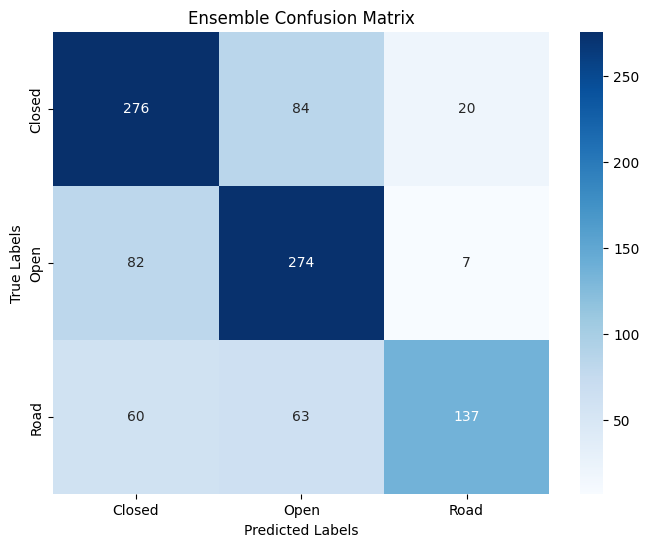

In [31]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Ensemble Confusion Matrix")
plt.show()

In [32]:
# Function to display the image with a given label
def showImg(img, name):
    plt.axis("off")
    plt.title(name)
    plt.imshow(img)
    plt.show()

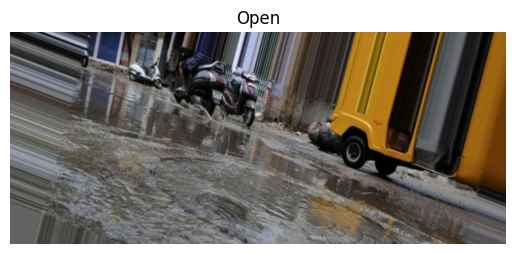

In [33]:
from random import seed, randint
x_ = randint(0, data_test_p.shape[0] - 1)
predicted_label = label_encoder.inverse_transform([ensemble_predictions[x_]])[0]
showImg(data_test[x_], predicted_label)